In [1]:
# ============================
# 1. Imports
# ============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm

# ============================
# 2. Device Config
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:
# ============================
# 3. Dataset & Dataloaders
# ============================
data_dir = "/kaggle/input/cucumber-disease-8-classes/Original Image"

# Transforms
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Split (70% train, 15% val, 15% test)
train_size = int(0.7 * len(dataset))
val_size   = int(0.15 * len(dataset))
test_size  = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Classes: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Gummy Stem Blight', 'Pythium Fruit Rot']
Train: 902, Val: 193, Test: 194


In [3]:
# ============================
# 4. Model, Loss, Optimizer
# ============================
# Load pretrained VGG19
model = models.vgg19(weights="IMAGENET1K_V1")

# Replace classifier
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 134MB/s]


In [4]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # -----------------------------
        # Training phase
        # -----------------------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"Train {epoch+1}/{epochs}", leave=False)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item())

        train_loss = running_loss / total
        train_acc  = correct / total

        # -----------------------------
        # Validation phase
        # -----------------------------
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        loop_val = tqdm(val_loader, desc=f"Val {epoch+1}/{epochs}", leave=False)

        with torch.no_grad():
            for images, labels in loop_val:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                preds = outputs.argmax(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                loop_val.set_postfix(loss=loss.item())

        val_loss /= val_total
        val_acc = val_correct / val_total

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history


# ============================
# Run Training
# ============================
num_epochs = 15
history = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device)



Epoch 1/15


Epoch 1/15 - Train Loss: 1.0684, Train Acc: 0.6131, Val Loss: 0.6501, Val Acc: 0.7565

Epoch 2/15


Epoch 2/15 - Train Loss: 0.4328, Train Acc: 0.8614, Val Loss: 0.6473, Val Acc: 0.7876

Epoch 3/15


Epoch 3/15 - Train Loss: 0.2784, Train Acc: 0.9069, Val Loss: 0.3592, Val Acc: 0.8756

Epoch 4/15


Epoch 4/15 - Train Loss: 0.1768, Train Acc: 0.9335, Val Loss: 1.1154, Val Acc: 0.7565

Epoch 5/15


Epoch 5/15 - Train Loss: 0.2656, Train Acc: 0.9213, Val Loss: 0.7667, Val Acc: 0.8601

Epoch 6/15


Epoch 6/15 - Train Loss: 0.1605, Train Acc: 0.9512, Val Loss: 0.5269, Val Acc: 0.8912

Epoch 7/15


Epoch 7/15 - Train Loss: 0.0835, Train Acc: 0.9745, Val Loss: 0.4150, Val Acc: 0.8549

Epoch 8/15


Epoch 8/15 - Train Loss: 0.0569, Train Acc: 0.9823, Val Loss: 0.5729, Val Acc: 0.8446

Epoch 9/15


Epoch 9/15 - Train Loss: 0.0277, Train Acc: 0.9922, Val Loss: 0.5471, Val Acc: 0.8860

Epoch 10/15


Epoch 10/15 - Train Loss: 0.0407, Train Acc: 0.9856, Val Loss: 0.4876, Val Acc: 0.8912

Epoch 11/15


Epoch 11/15 - Train Loss: 0.0505, Train Acc: 0.9867, Val Loss: 0.4107, Val Acc: 0.9067

Epoch 12/15


Epoch 12/15 - Train Loss: 0.0122, Train Acc: 0.9978, Val Loss: 0.4522, Val Acc: 0.9171

Epoch 13/15


Epoch 13/15 - Train Loss: 0.0319, Train Acc: 0.9900, Val Loss: 0.4151, Val Acc: 0.8860

Epoch 14/15


Epoch 14/15 - Train Loss: 0.0089, Train Acc: 0.9967, Val Loss: 0.5419, Val Acc: 0.9016

Epoch 15/15


Epoch 15/15 - Train Loss: 0.0009, Train Acc: 1.0000, Val Loss: 0.4413, Val Acc: 0.9275


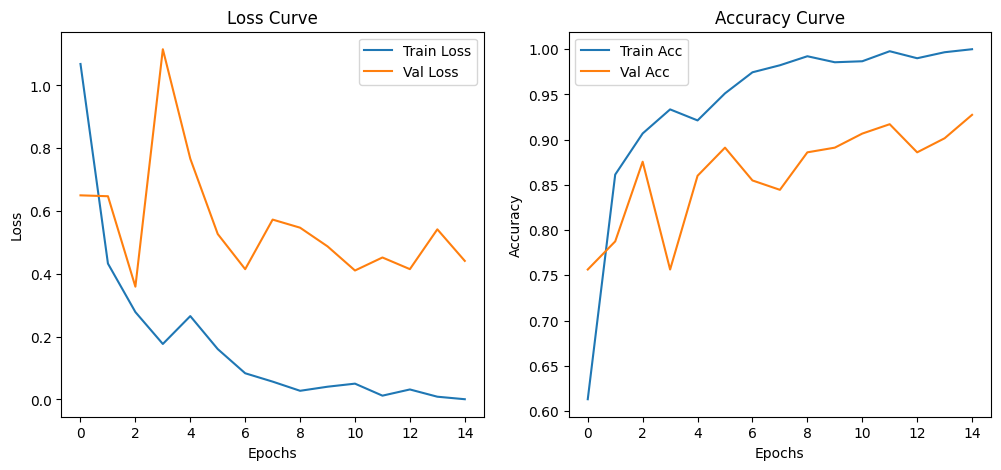

In [5]:
# ============================
# 6. Plot Training Curves
# ============================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy Curve")

plt.show()



Classification Report:

                   precision    recall  f1-score   support

      Anthracnose       0.85      0.67      0.75        33
   Bacterial Wilt       1.00      1.00      1.00        22
        Belly Rot       1.00      1.00      1.00        24
     Downy Mildew       0.86      0.92      0.89        26
   Fresh Cucumber       1.00      1.00      1.00        22
       Fresh Leaf       0.95      0.91      0.93        23
Gummy Stem Blight       0.62      0.80      0.70        20
Pythium Fruit Rot       1.00      1.00      1.00        24

         accuracy                           0.90       194
        macro avg       0.91      0.91      0.91       194
     weighted avg       0.91      0.90      0.90       194



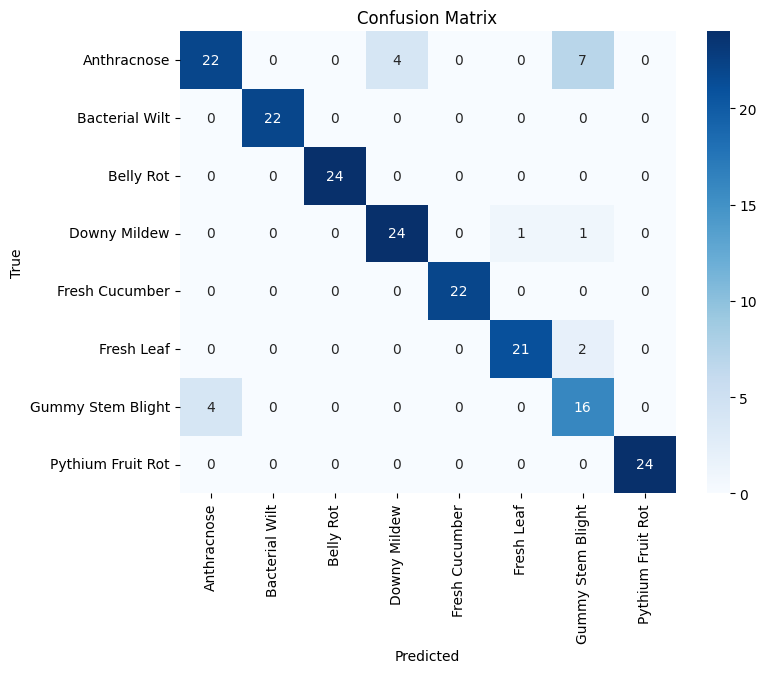

In [6]:
# ============================
# 7. Evaluate on Test Set
# ============================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
